# (06) DOVES—CategLin—0

**Motivation**: Categorical with ```1 x 512``` + DOVES + Lin encoder. ```prior_fit = False```. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'categorical'

## Archi: ```<lin|Lin>```

In [3]:
cfg_vae, cfg_tr = default_configs('DOVES', model_type, 'lin|lin')
cfg_vae['n_categories'] = 512
cfg_vae['n_latents'] = 1

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'DOVES', 'n_ch': 32, 'n_latents': 1, 'n_categories': 512, 'enc_type': 'lin', 'dec_type': 'lin', 
'enc_bias': False, 'dec_bias': False}

Trainer:
{'temp_stop': 0.1, 'temp_anneal_portion': 1.0, 'temp_anneal_type': 'exp', 'lr': 0.005, 'batch_size': 1000, 
'epochs': 3000, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500}

+----------------+------------+
|  Module Name   | Num Params |
+----------------+------------+
| CategoricalVAE |  262.1 K   |
|      ---       |    ---     |
|     fc_enc     |  131.1 K   |
|     fc_dec     |  131.1 K   |
+----------------+------------+

categorical-512_DOVES_z-1_<lin|lin>
mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(0.1:exp-1)_gr(500)_(2024_05_06,18:42)

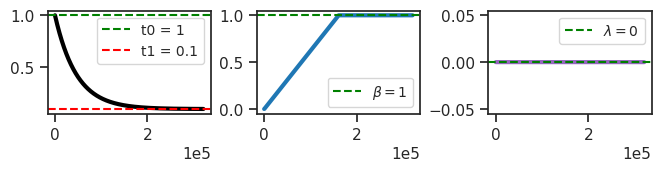

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [5]:
vae.fc_dec.bias, vae.fc_enc.bias

(None, None)

### Train

In [6]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 3000, avg loss: 172.895515: 100%|█████████████████████| 3000/3000 [1:16:14<00:00,  1.52s/it]


### Loss vld (freeze)

In [8]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 165.40834, 'kl': 5.581142, 'kl_diag': 5.567212, 'tot': 170.98949}

In [11]:
### Was: Bernoulli, Conv, fit_prior=True

{'mse': 155.9464, 'kl': 11.52797, 'kl_diag': 5.758477, 'tot': 167.47437}

In [26]:
### Was: 512 x 1, fixed prior

{'mse': 165.01498, 'kl': 5.632016, 'kl_diag': 5.6216135, 'tot': 170.647}

{'mse': 134.10709, 'kl': 28.86082, 'kl_diag': 0.056184433, 'tot': 162.96791}

{'mse': 133.72597, 'kl': 28.916742, 'kl_diag': 0.05594784, 'tot': 162.64272}

{'mse': 132.80032, 'kl': 29.794188, 'kl_diag': 0.05768895, 'tot': 162.59451}

### Plot enc/dec weights

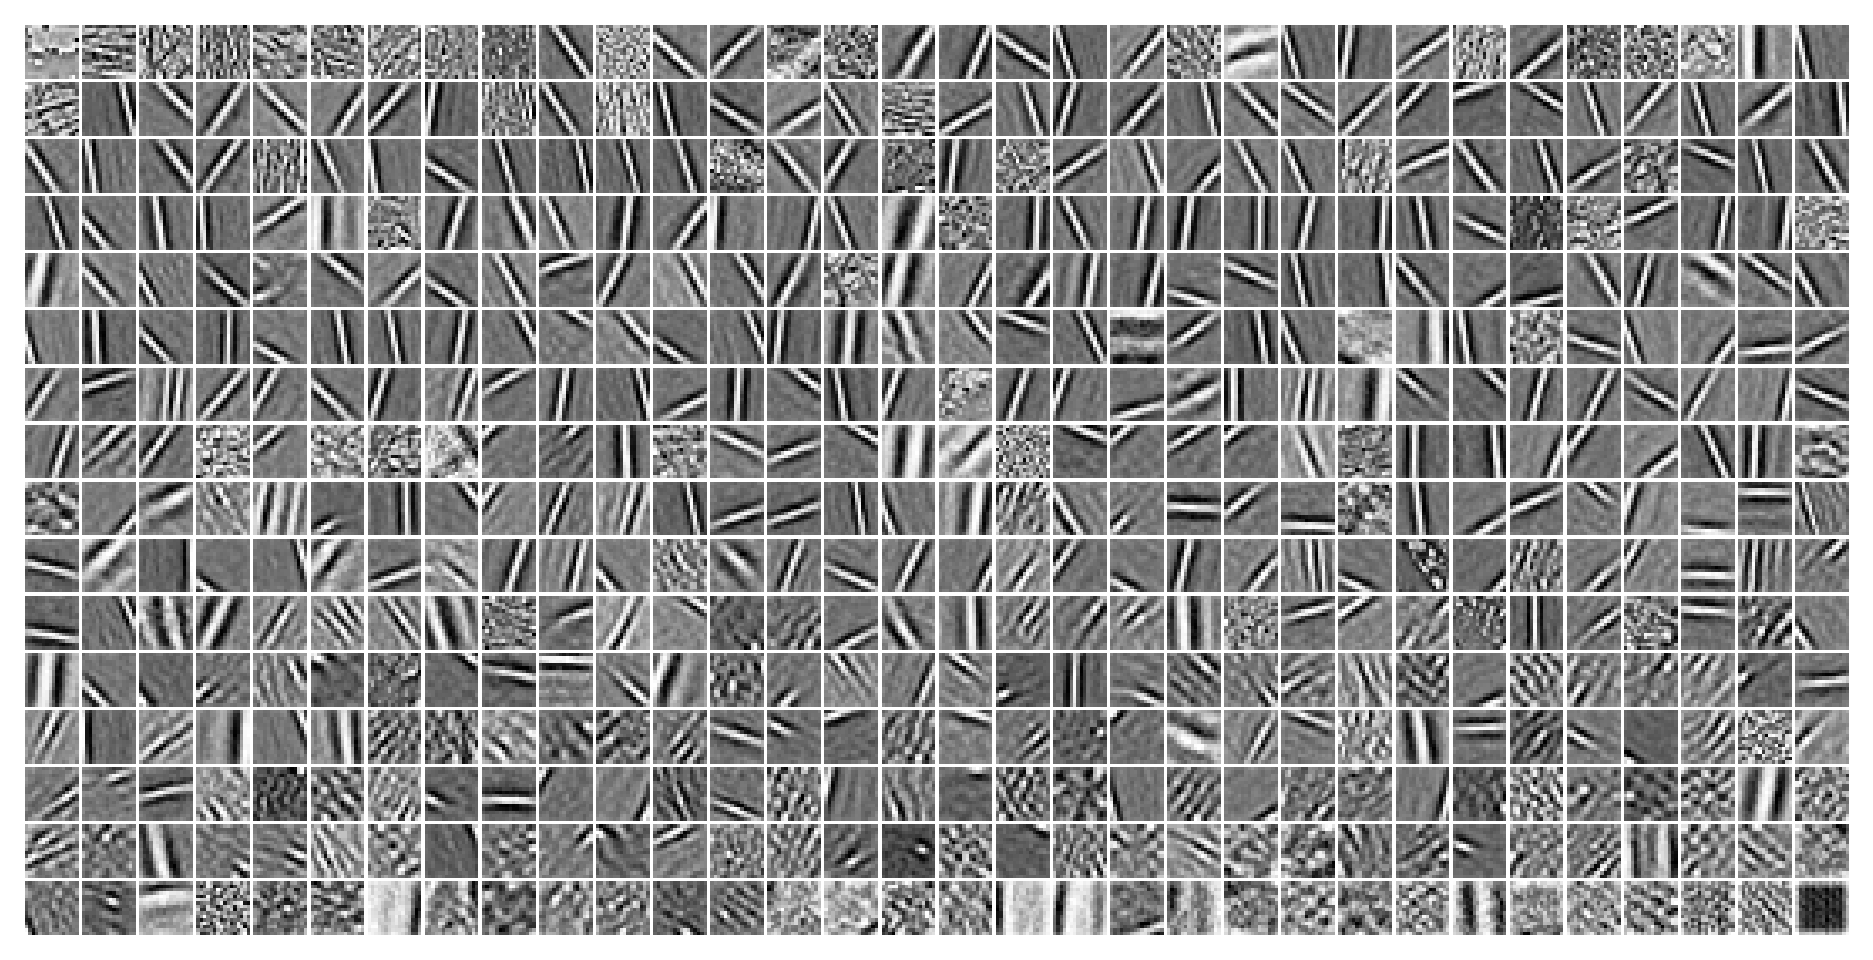

In [10]:
vae.show(dpi=250, order=np.argsort(flatten_np(etc['logits'], start_dim=1).mean(0)));

### Some more distributions

In [11]:
tr.model.temp, tr.cfg.kl_beta

(tensor(0.1009, device='cuda:0'), 1.0)

In [12]:
from base.distributions import dists

prior = dists.Categorical(vae.logits[0])
prior_probs = tonp(prior.probs).ravel()
prior_logits = tonp(prior.logits).ravel()

In [15]:
rv = sp_stats.norm(loc=prior_probs.mean(), scale=prior_probs.std())
xs = np.linspace(rv.ppf(1e-5), rv.ppf(1 - 1e-5), 101)
pdf = rv.pdf(xs)

In [16]:
rv.ppf(1e-5)

nan

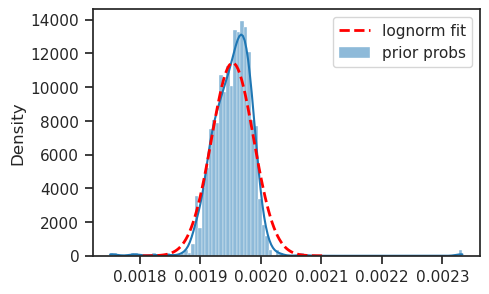

In [51]:
fig, ax = create_figure()

sns.histplot(prior_probs, stat='density', bins=100, kde=True, label='prior probs', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='lognorm fit')
add_legend(ax)
plt.show()

In [61]:
exclude = np.logical_or(
    prior_logits > np.quantile(prior_logits, 0.999),
    prior_logits < np.quantile(prior_logits, 1 - 0.999),
)
exclude.sum()

4

In [62]:
rv = sp_stats.norm(loc=prior_logits[~exclude].mean(), scale=prior_logits[~exclude].std())
xs = np.linspace(rv.ppf(1e-5), rv.ppf(1 - 1e-5), 101)
pdf = rv.pdf(xs)

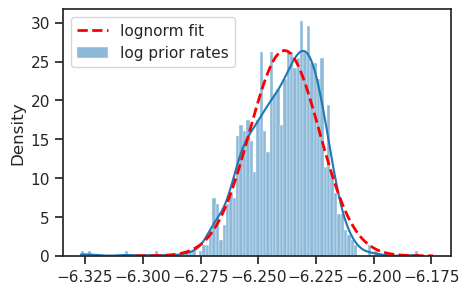

In [63]:
fig, ax = create_figure()

sns.histplot(prior_logits[~exclude], stat='density', bins=100, kde=True, label='log prior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='lognorm fit')
add_legend(ax)
plt.show()

In [64]:
sp_stats.kstest(prior_logits[~exclude], rv.cdf, method='exact')

KstestResult(statistic=0.05526713130181016, pvalue=0.003781269503779637, statistic_location=-6.2329464, statistic_sign=-1)

## Loggabor analysis

In [4]:
dead = np.zeros(np.prod(tr.model.size)).astype(bool)

In [5]:
from analysis.loggabor import fit_loggabor
from figures.theta import plot_theta
from figures.imgs import plot_weights

In [6]:
results = fit_loggabor(tr, verbose=True)

  7%|▊           | 34/512 [00:01<00:15, 30.41it/s]

 17%|██          | 87/512 [00:04<00:17, 23.84it/s]

 22%|██▍        | 112/512 [00:05<00:20, 19.78it/s]

 32%|███▌       | 166/512 [00:08<00:11, 28.93it/s]

 43%|████▋      | 219/512 [00:11<00:21, 13.72it/s]

 52%|█████▋     | 264/512 [00:13<00:07, 34.43it/s]

 58%|██████▍    | 299/512 [00:14<00:06, 31.03it/s]

 60%|██████▌    | 307/512 [00:14<00:07, 28.54it/s]

 62%|██████▊    | 319/512 [00:15<00:07, 26.07it/s]

 65%|███████▏   | 334/512 [00:16<00:10, 16.26it/s]

 75%|████████▏  | 382/512 [00:18<00:03, 32.71it/s]

 86%|█████████▍ | 439/512 [00:20<00:03, 21.97it/s]

 95%|██████████▍| 484/512 [00:23<00:01, 23.62it/s]

100%|███████████| 512/512 [00:24<00:00, 21.20it/s]


In [7]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan
results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,prior_probs
count,4.960000e+02,4.960000e+02,496.000000,494.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,7.445958e+00,7.613781e+00,0.104208,0.238695,-0.049999,0.410880,0.193965,89.075540,0.001953
std,3.172728e+00,3.636077e+00,0.990935,0.306911,1.490701,0.345734,0.228303,44.719977,0.000000
min,4.201158e-08,1.133470e-07,-1.561611,0.001000,-7.220899,0.023221,0.061524,0.636782,0.001953
25%,5.723405e+00,4.846327e+00,-0.835812,0.194264,-0.705268,0.306972,0.115717,51.572075,0.001953
50%,7.497686e+00,7.642734e+00,0.296643,0.218780,-0.098738,0.397393,0.147018,88.386228,0.001953
75%,9.330593e+00,1.059700e+01,0.961556,0.244360,0.523960,0.455218,0.207469,125.791635,0.001953
max,1.600000e+01,1.600000e+01,1.570796,6.133959,9.451870,6.875045,4.230440,179.387619,0.001953


In [12]:
try:
    key = results.columns[-1] if tr.model.cfg.fit_prior else 'kl'
    rates_axial = results.loc[(results['label'] == 'axial') & ~dead, key].values
    rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, key].values
    print(f"{sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')}")
    a, b = len(rates_axial), len(rates_oblique)
    print(a / (a+b), b / (a+b))
except KeyError:
    pass

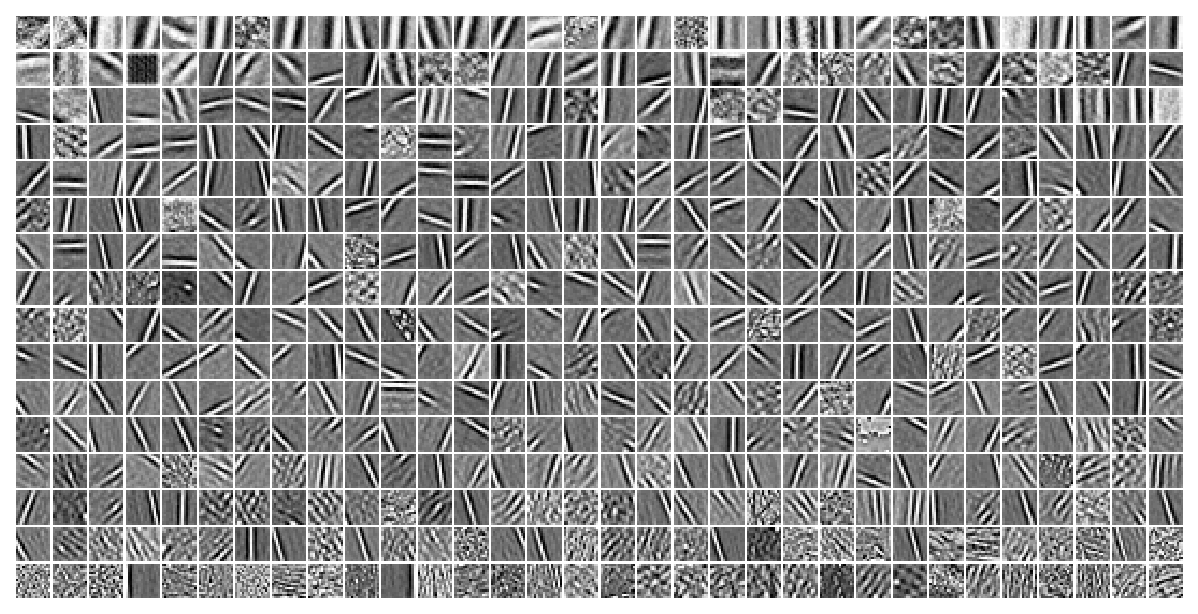

In [13]:
order = np.argsort(results['sf_0'].values)
_ = tr.model.show(order=order)

In [14]:
w_dec = tonp(tr.model.fc_dec.weight.data)
w_dec = w_dec.T.reshape(-1, 16, 16)
ids = np.argsort(results['sf_0'].values)

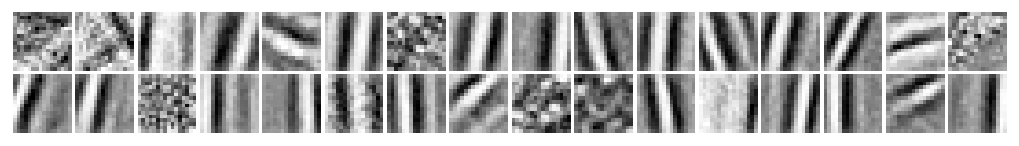

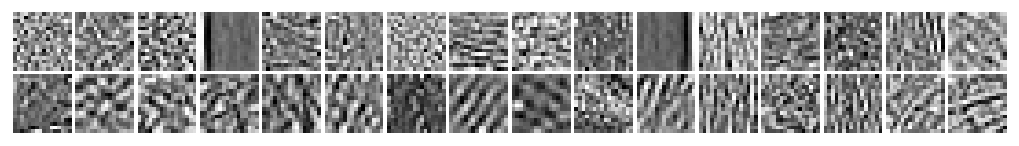

In [15]:
plot_weights(w_dec[ids[:32]], nrows=2, dpi=130)
plt.show()

plot_weights(w_dec[ids[-32:]], nrows=2, dpi=130)
plt.show()